# Senior Isolation Notebook


In [238]:
#importing modules
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt


#reading altarum and ipsos csv files, formatting dataframes
altarum_loneliness = pd.read_csv('Data/altarum_loneliness_data.csv')
altarum_visitors = pd.read_csv('Data/altarum_visitors_per_week_data.csv')
ipsos_loneliness = pd.read_csv('Data/ipsos_loneliness_data.csv')

altarum_loneliness = altarum_loneliness.set_index('Unnamed: 0')
altarum_visitors = altarum_visitors.set_index('Unnamed: 0')
ipsos_loneliness = ipsos_loneliness.set_index('Unnamed: 0')


#reading HRS data from .sas7bdat files, generated from original .da files given by HRS using SAS software
hrs12_lb = pd.read_sas('Data\h12lb_r.sas7bdat')
hrs12_n = pd.read_sas('Data\h12n_r.sas7bdat')
hrs12_prr = pd.read_sas('Data\h12pr_r.sas7bdat')

#setting basic styles and formatting for plots
%matplotlib inline 
plt.style.use("seaborn")

#ERROR: from pd.read_sas; known bug in pandas

c:\users\razfyz\vs code projects\senior isolation report\isolation_report_venv\lib\site-packages\pandas\io\sas\sas7bdat.py:800: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._byte_chunk[jb, :].view(dtype=self.byte_order + "d")
c:\users\razfyz\vs code projects\senior isolation report\isolation_report_venv\lib\site-packages\pandas\io\sas\sas7bdat.py:809: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._string_chunk[js, :]


In [239]:
# defining basic functions for data cleaning from HRS\

hrs_nadrop = ['NX067_R', 'NLB020A', 'NLB020B', 'NLB020C', 'NN147', 'NN099']

hrs_relevant = ['HHID', 'PN', 'NX067_R', 'ages', 'NLB020A', 'NLB020B', 'NLB020C', 'lonely_yn',
                            'NN099', 'NN100', 'NN101', 'NN147', 'NN207']


#determine if lonely if lonely 'NLB020A', 'NLB020B', or 'NLB020C' has value as < 3 (rationale below)
def det_lonely(df):
    lonely_yn_df = df.copy()
    lonely_yn_df['lonely_yn'] = False

    lonely_yn_df['lonely_yn'] = lonely_yn_df[(lonely_yn_df['NLB020A'] < 3) | (lonely_yn_df['NLB020B'] < 3) | 
                                          (lonely_yn_df['NLB020C'] < 3)]['lonely_yn'].map({False: True})
    lonely_yn_df['lonely_yn'] = lonely_yn_df['lonely_yn'].fillna(False)
    
    return lonely_yn_df


#data read in from HRS has non-integer identification numbers (HHID and PN); this function standardizes them as integers
def clean_id(df):
    cleaned_df =  df.copy()
    cleaned_df[['HHID', 'PN']] = cleaned_df[['HHID', 'PN']].astype(str).applymap(lambda x: x[2:-1]).astype(int)
    return cleaned_df


#data from HRS only provides year of birth; this function uses the survey year and birth year to calculate age in column 'ages'
def det_age(df, year):
    aged_df = df.copy()
    aged_df['ages'] = aged_df['NX067_R']
    aged_df.ages = aged_df.loc[:, 'ages'].apply(lambda x: x * -1 + year)
    return aged_df

#alternate det_age that does not create new 'ages' column
#    def det_age(df, year):
#        aged_df = df.copy()
#        aged_df.NX067_R = df.loc[:, 'NX067_R'].apply(lambda x: x * -1 + year)
#        return aged_df


#creates merged HRS dataframe from raw PR-R, LB, and N datafiles; determines if lonely (y/n), determines age, and cleans ids;
#drops rows without necessary data; filters out columns with unneeded information
def merge_hrs(df1, df2, df3, int_year):
    merged_df = reduce(lambda  left,right: pd.merge(left,right, on=['HHID', 'PN'], how='outer'), [df1, df2, df3])
    
    #alternate method to merge 3 dataframes
    #    hrs_2012_lbpr_r = hrs_2012_lb.merge(hrs_2012_pr_r, on=['HHID', 'PN'])
    #    hrs_2012_lbnpr_r = hrs_2012_lbpr_r.merge(hrs_2012_n, on=['HHID', 'PN'])
    
    #dropping participants with ANY blank values within the necessary fields
    merged_df_drop = merged_df.dropna(axis='index', how='any', subset=hrs_nadrop)
    
    #determine if 'lonely' according to definition
    merged_lonely_yn = det_lonely(merged_df_drop) 
    
    #clean HHID and PN
    merged_cid = clean_id(merged_lonely_yn)
    
    #determine age from birth year and year of interview
    merged_aged = det_age(merged_cid, int_year)
    
    #set NaN values in N100 (number of nights spent in hospital) to zero; HRS data codebook implies NaN values mean 0 nights
    merged_aged['NN100'] = merged_aged['NN100'].fillna(0)
    
    #get only relevent columns in final merged df
    merged_final = merged_aged[hrs_relevant]
    
    return merged_final

In [240]:
hrs12m = merge_hrs(hrs12_lb, hrs12_n, hrs12_prr, 2012)

HRS: Loneliness as function of age

Altarum Survey: Loneliness increase after restrictions implemented

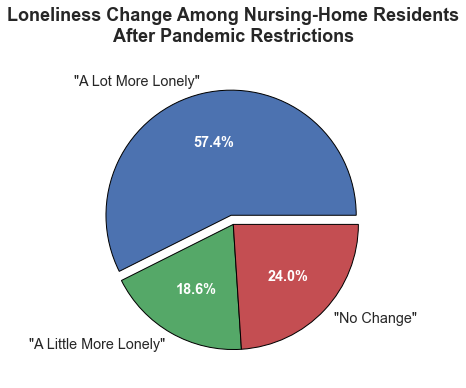

In [213]:
#manipulating dataframe to input into 'plt.pie'
alt_loneliness_series = altarum_loneliness.unstack(1)

#setting labels for each section of the pie chart
labels = ["\"A Lot More Lonely\"", "\"A Little More Lonely\"", "\"No Change\""]

#parameters for explode
explode = [0.075, 0, 0]

#rendering the pie chart with styling
plt.title("Loneliness Change Among Nursing-Home Residents\nAfter Pandemic Restrictions\n", fontsize=18, fontweight='bold')
patches, texts, pcts = plt.pie(alt_loneliness_series, labels=labels, wedgeprops={'edgecolor': 'black', 'linewidth': 1}, 
                            autopct='%1.1f%%', explode=explode, textprops={'size': 'x-large'})
plt.setp(pcts, color='white', fontweight='bold')

plt.tight_layout()
plt.show()

Altarum Survey: Visitors before and after restrictions implemented

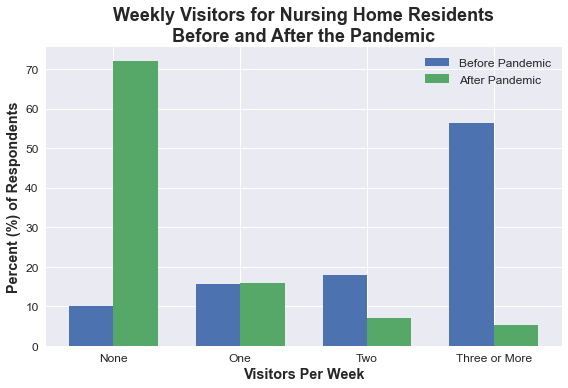

In [214]:
# %matplotlib notebook

#manipulating dataframe to create two series with data for the double bar graph
visitors_pre_rest = altarum_visitors.iloc[0]
visitors_post_rest = altarum_visitors.iloc[1]

#set manual bar width and 'x_indexes' to make offsets possible
x_indexes = np.arange(len(visitors_pre_rest))
width = 0.35

#rendering double bar graph with styling
plt.title("Weekly Visitors for Nursing Home Residents\nBefore and After the Pandemic", 
                            fontsize=18, fontweight='bold')
plt.bar(x_indexes - width/2, visitors_pre_rest, width=width, label='Before Pandemic')
plt.bar(x_indexes + width/2, visitors_post_rest, width=width, label='After Pandemic')

#NOTE: add 'edgecolor='black', linewidth=1' to plt.bar if you want to add borders to each of the bars

plt.xlabel('Visitors Per Week', fontsize='x-large', fontweight='bold')
plt.ylabel('Percent (%) of Respondents', fontsize='x-large', fontweight='bold')
plt.xticks(ticks=x_indexes, labels=['None', 'One', 'Two', 'Three or More'], fontsize='large')
plt.yticks(fontsize='large')

plt.legend(fontsize='large')
plt.tight_layout()
plt.show()

Ipsos Survey: Loneliness among all Americans (and entire world) from COVID (((( **DELETE** ))))

In [215]:
'''
usa_pcts = ipsos_loneliness.iloc[0]
wrld_pcts = ipsos_loneliness.iloc[1]

labels = ["\"More Lonely\"", "\"Less Lonely\"", "\"No Change\""]

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

ax1.set_title("USA: Loneliness Change\nDuring Pandemic\n", fontsize=18, fontweight='bold')
patches, texts, pcts = ax1.pie(usa_pcts, labels=labels, wedgeprops={'edgecolor': 'black', 'linewidth': 1}, 
                            autopct='%1.1f%%', textprops={'size': 'x-large'}, startangle=200)
plt.setp(pcts, color='white', fontweight='bold')

ax2.set_title("World: Loneliness Change\nDuring Pandemic\n", fontsize=18, fontweight='bold')
patches, texts, pcts = ax2.pie(wrld_pcts, labels=labels, wedgeprops={'edgecolor': 'black', 'linewidth': 1}, 
                            autopct='%1.1f%%', textprops={'size': 'x-large'}, startangle=200)
plt.setp(pcts, color='white', fontweight='bold')

plt.show()
'''

'\nusa_pcts = ipsos_loneliness.iloc[0]\nwrld_pcts = ipsos_loneliness.iloc[1]\n\nlabels = [""More Lonely"", ""Less Lonely"", ""No Change""]\n\nfig1, ax1 = plt.subplots()\nfig2, ax2 = plt.subplots()\n\nax1.set_title("USA: Loneliness Change\nDuring Pandemic\n", fontsize=18, fontweight=\'bold\')\npatches, texts, pcts = ax1.pie(usa_pcts, labels=labels, wedgeprops={\'edgecolor\': \'black\', \'linewidth\': 1}, \n                            autopct=\'%1.1f%%\', textprops={\'size\': \'x-large\'}, startangle=200)\nplt.setp(pcts, color=\'white\', fontweight=\'bold\')\n\nax2.set_title("World: Loneliness Change\nDuring Pandemic\n", fontsize=18, fontweight=\'bold\')\npatches, texts, pcts = ax2.pie(wrld_pcts, labels=labels, wedgeprops={\'edgecolor\': \'black\', \'linewidth\': 1}, \n                            autopct=\'%1.1f%%\', textprops={\'size\': \'x-large\'}, startangle=200)\nplt.setp(pcts, color=\'white\', fontweight=\'bold\')\n\nplt.show()\n'

NSHAP: Correlations of loneliness with depression and aniety among elderly 

HRS: Increased number of physician visits (and hospitalizations) when lonely

In [254]:
#when using, input column argument within single quotations; ex: hrs_visits(hrs12mc, 'NN147', 998, 999)
def hrs_visits(df, column, DK_val, RF_val):
    dfc = df.copy()
    
    #numeric DK_val and RF_val indicate "Don't Know" and "Refused [to answer]" respectively in the data; drop those values
    dfc_clean = dfc[(dfc[column] != DK_val) & (dfc[column] != RF_val)]
    
    #setting values within such that over 99th percentile of doctor visits is replaced with the 99th percentile value
    #this is done in order to control for the disproportionately large outliers within the raw data (ex: 900 physician visits)
    dfc_clean.loc[dfc_clean[column] >= dfc_clean[column].quantile(.99), column] = dfc_clean[column].quantile(.99)
    
    #return descriptive statistics about the loneliness (count, mean, standard deviation, quarentiles, etc) to be used in plots
    lonely_y = dfc_clean[dfc_clean.lonely_yn == True][column].describe()
    lonely_n = dfc_clean[dfc_clean.lonely_yn == False][column].describe()
    return [lonely_y, lonely_n]

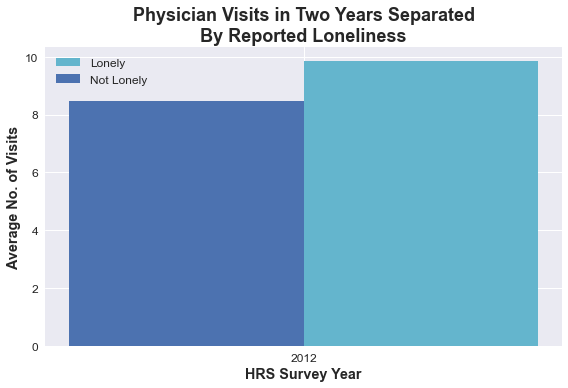

In [297]:
#num doctor visits and loneliness

#create lists with mean number of visits, separated by whether reported feeling lonely or not
lonely_dvisits = []
nlonely_dvisits = []

lonely_dvisits.append(hrs_visits(hrs12m, 'NN147', 998, 999)[0]['mean'])

nlonely_dvisits.append(hrs_visits(hrs12m, 'NN147', 998, 999)[1]['mean'])

#set manual bar width and 'x_indexes' to make offsets possible
x_indexes = np.arange(len(lonely_dvisits))
width = 0.35

#rendering double bar graph with styling
plt.title("Physician Visits in Two Years Separated\nBy Reported Loneliness", 
                            fontsize=18, fontweight='bold')
plt.bar(x_indexes + width/2, lonely_dvisits, width=width, label='Lonely', color='#64b5cd')
plt.bar(x_indexes - width/2, nlonely_dvisits, width=width, label='Not Lonely')

#NOTE: add 'edgecolor='black', linewidth=1' to plt.bar if you want to add borders to each of the bars

plt.xlabel('HRS Survey Year', fontsize='x-large', fontweight='bold')
plt.ylabel('Average No. of Visits', fontsize='x-large', fontweight='bold')
plt.xticks(ticks=x_indexes, labels=['2012'], fontsize='large')
plt.yticks(fontsize='large')

plt.legend(fontsize='large')
plt.tight_layout()
plt.show()

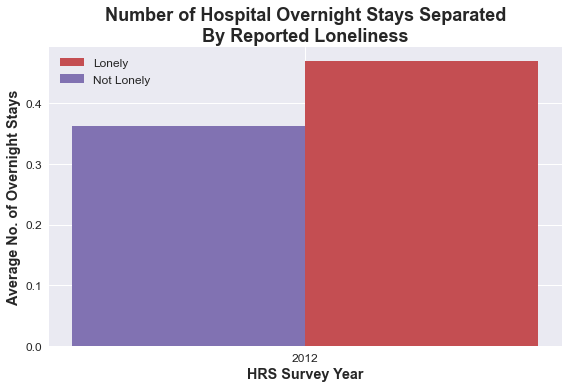

In [293]:
#num hospital overnight stays

#create lists with mean number of visits, separated by whether reported feeling lonely or not
lonely_hstays = []
nlonely_hstays = []

lonely_hstays.append(hrs_visits(hrs12m, 'NN100', 98, 99)[0]['mean'])

nlonely_hstays.append(hrs_visits(hrs12m, 'NN100', 98, 99)[1]['mean'])

#set manual bar width and 'x_indexes' to make offsets possible
x_indexes = np.arange(len(lonely_hstays))
width = 0.35

#rendering double bar graph with styling
plt.title("Number of Hospital Overnight Stays Separated\nBy Reported Loneliness", 
                            fontsize=18, fontweight='bold')
plt.bar(x_indexes + width/2, lonely_hstays, width=width, label='Lonely', color='#c44e52')
plt.bar(x_indexes - width/2, nlonely_hstays, width=width, label='Not Lonely', color='#8172b2')

#NOTE: add 'edgecolor='black', linewidth=1' to plt.bar if you want to add borders to each of the bars

plt.xlabel('HRS Survey Year', fontsize='x-large', fontweight='bold')
plt.ylabel('Average No. of Overnight Stays', fontsize='x-large', fontweight='bold')
plt.xticks(ticks=x_indexes, labels=['2012'], fontsize='large')
plt.yticks(fontsize='large')

plt.legend(fontsize='large')
plt.tight_layout()
plt.show()